In [111]:
import os
import ember
import lightgbm as lgb
import shap
import numpy as np
import pandas as pd
from pandas import json_normalize

binary_name = "DUAL_COUGH" #set this to the binary name, put the ones u want to test in /binaries

data_dir = "../ember2018/"

In [112]:
# ~4 mns
binary_location = f"/workspaces/torment-nexus/binaries/{binary_name}"

emberdf = ember.read_metadata(data_dir)
X_train, y_train, X_test, y_test = ember.read_vectorized_features(data_dir, feature_version=2)
lgbm_model = lgb.Booster(model_file=os.path.join(data_dir, "ember_model_2018.txt"))
lgbm_model.params['objective'] = 'regression' # dunno why this never gets set but its needed for shap

In [113]:
extractor1 = ember.PEFeatureExtractor(1)
extractor2 = ember.PEFeatureExtractor(2)

file_data = open(binary_location, "rb").read()

feature_vector = extractor2.feature_vector(file_data)
raw_features = extractor2.raw_features(file_data)

lief error:  This file is not a PE binary
lief error:  This file is not a PE binary


In [114]:
# holy shit this was something else

byte_histogram = [f"Byte Histogram {a}" for a in range(256)] #256

byte_entropy_histogram = [f"Byte Entropy Histogram {a}" for a in range(256)] #256

strings = [f"string.{a}" for a in ["numstrings", "avlength", "printables", 
                                          [f"printabledist {b}" for b in range(len(raw_features["strings"]["printabledist"]))],
                                          "entropy", "paths", "urls", "registry", "MZ"]
                  for _ in (a if isinstance(a, list) else [a])
                  ] # 8 + 96

general_info = [f"general.{a}" for a in ["size", "vsize", "has_debug", "exports", "imports", "has_relocations", "has_resources", "has_signature", "has_tls", "symbols"]]

header_coff = ["header.coff.timestamp"]
header_coff_machine = [f"header.coff.machine_{a}" for a in range(10)]
header_coff_characteristics = [f"header.coff.characteristic_{a}" for a in range(10)]
header_coff_subsystem = [f"header.optional.subsystem_{a}" for a in range(10)]
header_coff_dll_characteristics = [f"header.optional.dll_characteristic_{a}" for a in range(10)]
header_coff_magic = [f"header.optional.magic_{a}" for a in range(10)]
header_optional = [f"header.optional.{a}" for a in ["major_image_version", "minor_image_version", "major_linker_version", "minor_linker_version", "major_operating_system_version", "minor_operating_system_version", "major_subsystem_version", "minor_subsystem_version", "sizeof_code", "sizeof_headers", "sizeof_heap_commit"]] #12
header = np.concatenate((header_coff,header_coff_machine,header_coff_characteristics,header_coff_subsystem,header_coff_dll_characteristics,header_coff_magic,header_optional))

sections_general = [f"sections.{a}" for a in ["section_count", "num_empty_sections", "num_unnamed_sections", "num_read_execute_sections", "num_write_sections",]] #JUST general
sections_section_sizes = [f"sections.section_{a}_size" for a in range(50)] # this messes with hashing which i will understand at a later time
sections_section_entropy = [f"sections.section_{a}_entropy" for a in range(50)]
sections_section_vsize = [f"sections.section_{a}_vsize" for a in range(50)]
sections_entry_name = [f"sections.entry_name_{a}" for a in range(50)]
sections_characteristics = [f"sections.characteristics_{a}" for a in range(50)]
sections = np.concatenate((sections_general, sections_section_sizes, sections_section_entropy, sections_section_vsize, sections_entry_name, sections_characteristics))

imports_libraries = [f"imports.libraries.library_{a}" for a in range(256)]
imports_imports = [f"imports.import_{a}" for a in range(1024)]
imports = np.concatenate((imports_libraries,imports_imports))

exports = [f"exports.export_{a}" for a in range(128)]

name_order = [a.lower() for a in ["EXPORT_TABLE", "IMPORT_TABLE", "RESOURCE_TABLE", "EXCEPTION_TABLE", "CERTIFICATE_TABLE","BASE_RELOCATION_TABLE", "DEBUG", "ARCHITECTURE", "GLOBAL_PTR", "TLS_TABLE", "LOAD_CONFIG_TABLE","BOUND_IMPORT", "IAT", "DELAY_IMPORT_DESCRIPTOR", "CLR_RUNTIME_HEADER"]]
data_directories_unflat = [[f"directories.{a}_size", f"directories.{a}_vaddress"] for a in name_order]
data_directories = [item for sublist in data_directories_unflat for item in sublist]



feature_names = np.concatenate((byte_histogram, byte_entropy_histogram, strings, general_info, header, sections, imports, exports, data_directories))

[len(byte_histogram) == 256, 
 len(byte_entropy_histogram) == 256, 
 len(strings) == 1 + 1 + 1 + 96 + 1 + 1 + 1 + 1 + 1,
 len(general_info) == 10,
 len(header) == 62, 
 len(sections) == 5 + 50 + 50 + 50 + 50 + 50,
 len(imports) == 1280,
 len(exports) == 128,
 len(data_directories) == 15 * 2,
 len(feature_names) == 2381 # Checks if the feature names are all properly assigned
]

[True, True, True, True, True, True, True, True, True]

In [117]:
# explainer = shap.TreeExplainer(lgbm_model, feature_names=get_all_keys(raw_features))
explainer = shap.TreeExplainer(lgbm_model, feature_names=feature_names)
# explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer(pd.DataFrame(X_train[:10]))
shap_values_single = explainer(np.array([feature_vector], dtype=np.float32))

In [118]:
shap.initjs()
# shap.force_plot(shap_values) # this isnt really useful but if you want to look you can

# Plot output

In [119]:
shap.force_plot(shap_values_single)

In [120]:
"""
You can see in the above graph that all of the features still have "Feature XXXX" instead of an actual name.
Forunately, there is something resembling a feature name that you can see below
"""
np.array(raw_features)

array({'sha256': '25d3e4916bbf90e25c9f303eb23a550fa5f9bdb175e592782401dca6823f2d06', 'histogram': [2989892, 431415, 332850, 156179, 182924, 222024, 103800, 92645, 174601, 84785, 93647, 63049, 57778, 51835, 42659, 292519, 106398, 43495, 32708, 41597, 40272, 32161, 26313, 25874, 65437, 26017, 23706, 25276, 21933, 24006, 21014, 66399, 68221, 21863, 18934, 14294, 653981, 23260, 19495, 14686, 49436, 44167, 28909, 13298, 17682, 13399, 114354, 12685, 57881, 116567, 39879, 31193, 36889, 30424, 33218, 30426, 52406, 61598, 13308, 27047, 16374, 28840, 10562, 15254, 78499, 49833, 33925, 61776, 376898, 41250, 38529, 36484, 828972, 87635, 34263, 31824, 210413, 52423, 32021, 31852, 103142, 33799, 37392, 33184, 114253, 30338, 29335, 32277, 47242, 29353, 30072, 14502, 63388, 10901, 10451, 32781, 38585, 39272, 31685, 42369, 39531, 51209, 81101, 90587, 46360, 43369, 27743, 29520, 130964, 35522, 49503, 95102, 51383, 29377, 48384, 59874, 70986, 69090, 35435, 29421, 45100, 27399, 50521, 13116, 31164, 13335,

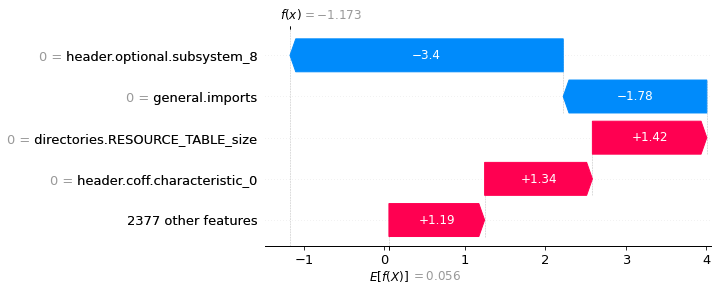

In [121]:
shap.plots.waterfall(shap_values_single[0], max_display=5) # this does not work with labels yet

In [122]:
y_train

memmap([0., 0., 0., ..., 0., 1., 1.], dtype=float32)

In [123]:
extractor2.process_raw_features(raw_features).shape

(2381,)

In [124]:
feature_vectors = [fe.process_raw_features(raw_features[fe.name]) for fe in extractor2.features]

In [125]:
pd.DataFrame(np.hstack(feature_vectors).astype(np.float32))

,0
0,0.180771
1,0.026084
2,0.020124
3,0.009443
4,0.011060
...,...
2376,0.000000
2377,0.000000
2378,0.000000
2379,0.000000


In [126]:
for a in raw_features["strings"].keys():
    print(type(raw_features["strings"][a]))


<class 'int'>
<class 'float'>
<class 'list'>
<class 'int'>
<class 'float'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


In [127]:
raw_features["general"]

{'size': 16539648,
 'vsize': 0,
 'has_debug': 0,
 'exports': 0,
 'imports': 0,
 'has_relocations': 0,
 'has_resources': 0,
 'has_signature': 0,
 'has_tls': 0,
 'symbols': 0}